# Calculate NDMI & Reclassify the Values based on Interval Metrics
This notebook will demonstrate how to calculate interval metrics of NDMI at two time points presented in [Metrics That Makes Difference](https://link.springer.com/book/10.1007/978-3-030-70765-1) (Pontius Jr., 2022). We also present two novel approaches of reclassification based on the metrics of Pontius Jr. (2022).

## Step1: Import Packages & NDMI Images from Two Time points
For this demonstration, we will import an NDMI images at 2010, obtained by Landsat5, and that at 2020, obtained by Landsat8. Our study region is Richao Das Neves, Bahia, Brazil, so we mosaic and clipped the raster images. We also calculate deviation that is subtraction from the later image by the former image.

Further references include:
- [Normalized Difference Moisture Index](https://www.usgs.gov/landsat-missions/normalized-difference-moisture-index)
- [Calculate NDVI](https://autogis-site.readthedocs.io/en/2019/notebooks/Raster/raster-map-algebra.html#calculating-ndvi)
    - Note you have to change bands to calculate NDMI.
- [Mosaic Raster](https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html)
- [Mask Raster](https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)

In [1]:
# IMPORT PACKAGES####
import rasterio as rio
from rasterio.plot import show

import numpy as np

import scipy as sp
from scipy import stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt

from pytoc import TOC
from pytoc import TOC_painter

import os

In [2]:
# CHANGE WORKING DIRECTORY####
os.chdir("/Volumes/volume 1/GIS Projects/GISMapComparison/output/regions")

In [3]:
# READ DATA####
ndmi2010 = rio.open("ndmi2010Rdn.tif")
ndmi2020 = rio.open("ndmi2020Rdn.tif")

# Convert Raster into Array====
arr2010 = ndmi2010.read(1)
arr2020 = ndmi2020.read(1)

# Calculate Deviation====
dev = arr2020 - arr2010

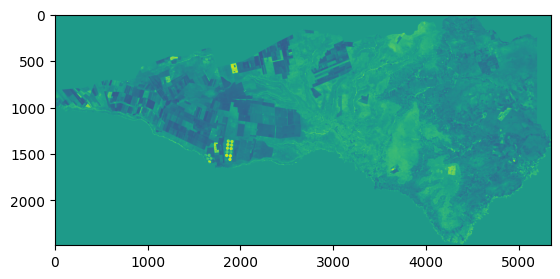

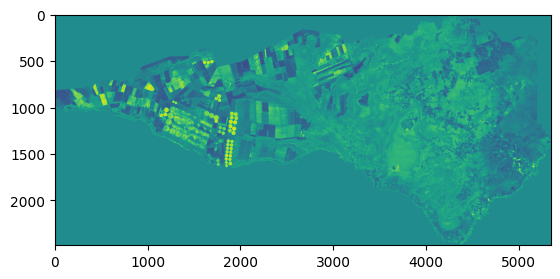

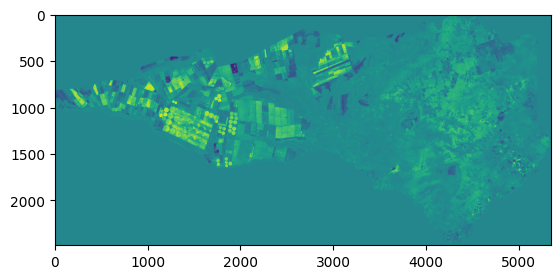

<AxesSubplot: >

In [4]:
# PLOT DATA####
show(arr2010)
show(arr2020)
show(dev)

When I calculate NDMI, I inserted 0 to pixels which are located outside of boundary. Therefore, I want to remove them. To do this, I will insert NaN values where deviation is 0, because 0 - 0 = 0.
If you have used other values, you might want to skip this phase.

In [5]:
# INSERT NAN VALUES####
arr2010[dev == 0] = np.nan
arr2020[dev == 0] = np.nan
dev[dev == 0] = np.nan

In [6]:
print(arr2010)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [7]:
# CREATE NEW ARRAYS WITHOUT NAN TO SIMPLIFY CALCULATION####
x = arr2010[~np.isnan(arr2010)]
y = arr2020[~np.isnan(arr2010)]
d = dev[~np.isnan(dev)]
print(x)

[0.0714139  0.06369595 0.1283053  ... 0.11616432 0.13867609 0.12452602]


## Step2: Calculate 4 Metrics from Pontius Jr. (2022)
Now that we read the datasets, we now calculate 4 interval metrics, which are MD, MAD, correlation, and slope to get an overview of NDMI values and their deviation between the two time points. See [Metrics That Makes Difference](https://link.springer.com/book/10.1007/978-3-030-70765-1) (Pontius Jr., 2022) for further information.

In [8]:
# CALCULATE MEAN X AND Y####
meanX = x.mean()
meanY = y.mean()
print("Mean X: ", meanX)
print("Mean Y: ", meanY)

Mean X:  -0.027959153
Mean Y:  0.02417777


Mean deviation is mean Y minus mean X.

In [9]:
# CALCULATE MEAN DEVIATION####
md = meanY - meanX
print("Mean Deviation: ",md)

Mean Deviation:  0.05213692


We first calculate all absolute values of the individual deviations, and then calculate their mean.

In [10]:
# CALCULATE MAD####
mad = np.absolute(d).mean()
print("Mean Absolute Deviation: ", mad)

Mean Absolute Deviation:  0.076124705


We use `scipy.stats` package to calculate correlation and slope.

In [11]:
# CALCULATE CORRELATION & SLOPE####
lmResult = st.linregress(x, y)
print("Correlation: ", lmResult.rvalue)
print("Slope: ", lmResult.slope)

Correlation:  0.2702759968977008
Slope:  0.3371574071491269


We will show scatter plot of the NDMI values at 2010 and 2020. The plot also shows mean X and mean Y, as well as the least square line showing the slope. See [`matplotlib.pyplot` documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) for detailed parameters.

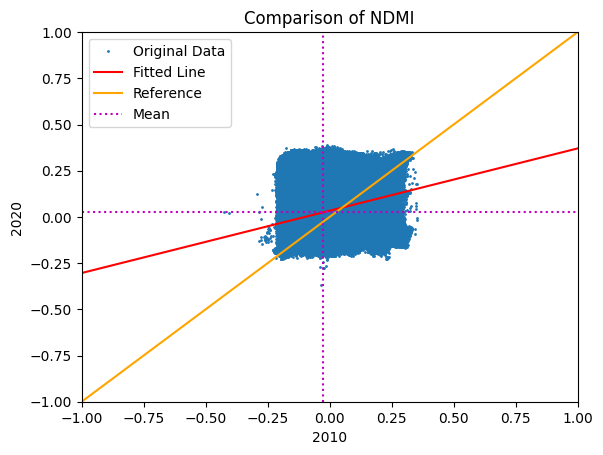

In [12]:
# PLOT DATA####
# Define Data and Dots' Shapes====
plt.plot(x, 
         y, 
         "o", 
         # Define label----
         label = "Original Data", 
         markersize = 1)

# Define X Limits and Y Limits so that They Have the Same Scale and Bounds====
xLim = [-1, 1]
yLim = [-1, 1]

# Plot Least Square Line====
# Define x bounds----
plt.plot(xLim, 
         # Define minimum y: multiply -1 by slope and add intercept----
         [lmResult.intercept + lmResult.slope*xLim[0], 
         # Define maximum y: multiply 1 by slope and add intercept
          lmResult.intercept + lmResult.slope*xLim[1]], 
         # Define color----
         "r", 
         # Define 
         label = "Fitted Line")

# Plot 1:1 Line====
plt.plot(xLim, yLim, "orange", label = "Reference")

# Plot X Mean Line====
plt.plot([meanX, meanX], yLim, "m:", label = "Mean")

# Plot Y Mean Line====
plt.plot(xLim, [meanY, meanY], "m:")

# Define Other Properties====
plt.title("Comparison of NDMI")
plt.xlabel("2010")
plt.ylabel("2020")
plt.xlim(xLim)
plt.ylim(yLim)
plt.plot()
plt.legend()
plt.show()

## STEP3: RECLASSIFY RASTER VALUES
Now we know of how NDMI changed during the time interval. We want to present two novel reclassification methods of raster values.
The first method is so called quadrant reclassification. Its strength includes clearity of comparison between pixel values and mean values at two time points.
The second method is so called MAD reclassification. Its strength includes simplicity of quantifying deviations.

In [13]:
# CREATE QUADRANT RASTER####
recArr2010 = np.where(arr2010 > meanX,
                      1,
                      0)
recArr2020 = np.where(arr2020 > meanY,
                      1,
                      0)

quad = arr2010.copy()
quad[recArr2010 + recArr2020 ==2] = 1
quad[recArr2010 + recArr2020 == 0] = 3
quad[recArr2010 - recArr2020 == 1] = 4
quad[recArr2010 - recArr2020 == -1] = 2

# Overwrite OutOfBoundary with 0====
quad[np.isnan(dev)] = 0

np.unique(quad)

array([0., 1., 2., 3., 4.], dtype=float32)

<AxesSubplot: >

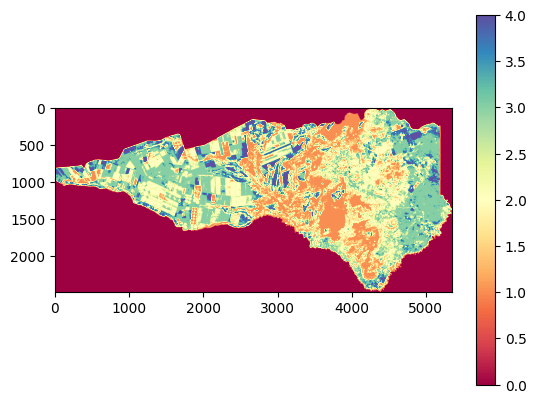

In [14]:
# PLOT QUADRANT IMAGE####
fig, ax = plt.subplots()
img = ax.imshow(quad, cmap='Spectral')
# Show Legend====
fig.colorbar(img, ax=ax)
show(quad, ax=ax, cmap='Spectral')

In [15]:
# CREATE MAD RASTER####
madr = arr2010.copy()

madr[dev > mad] = 1
madr[dev < -1* mad] = 2
madr[np.absolute(dev) <= mad] = 3
madr[np.isnan(dev)] = 0

print(np.unique(madr))

[0. 1. 2. 3.]


<AxesSubplot: >

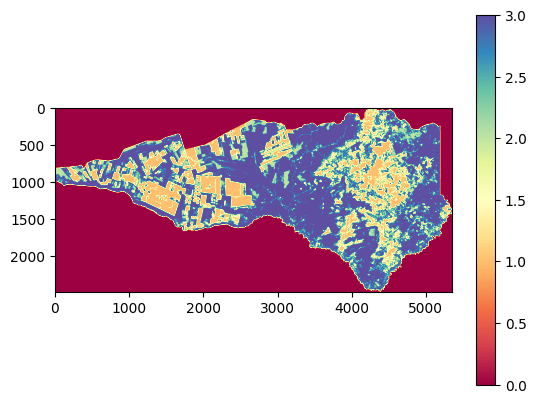

In [16]:
# PLOT QUADRANT IMAGE####
fig, ax = plt.subplots()
img = ax.imshow(madr, cmap='Spectral')
# Show Legend====
fig.colorbar(img, ax=ax)
show(madr, ax=ax, cmap='Spectral')

Now we have quadrant and MAD reclassification map. We now combine them to examine associations between the reclassification result and  irrigation gain during the time interval of 2010 and 2020. (Please notify me if you have an alternative way to combine the values...)

[ 0.  1.  2.  3.  4.  6.  7.  8.  9. 11. 12.]


<AxesSubplot: >

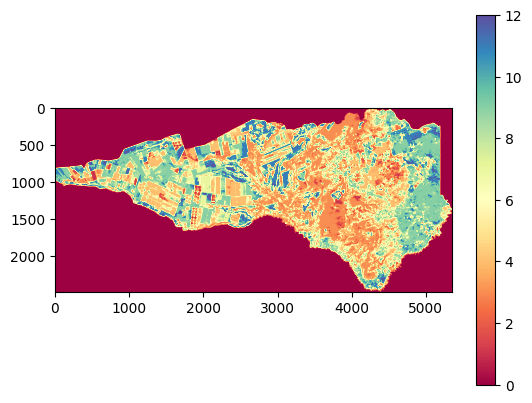

In [17]:
combined = quad.copy()
# Reclassify Quadrant 1====
# Assign 1 to Positive Deviation > MAD----
combined[np.where((quad == 1) & (madr == 1))] = 1
# Assign 2 to Positive Abs Negative Deviation > MAD----
combined[np.where((quad == 1) & (madr == 2))] = 2
# Assign 2 to Positive Abs Deviation <= MAD----
combined[np.where((quad == 1) & (madr == 3))] = 3

# Reclassify Quadrant 2====
# Assign 4 to Positive Deviation > MAD----
combined[np.where((quad == 2) & (madr == 1))] = 4
# Assign 5 to Positive Abs Negative Deviation > MAD----
combined[np.where((quad == 2) & (madr == 2))] = 5
# Assign 6 to Positive Abs Deviation <= MAD----
combined[np.where((quad == 2) & (madr == 3))] = 6

# Reclassify Quadrant 3====
# Assign 7 to Positive Deviation > MAD----
combined[np.where((quad == 3) & (madr == 1))] = 7
# Assign 8 to Positive Abs Negative Deviation > MAD----
combined[np.where((quad == 3) & (madr == 2))] = 8
# Assign 9 to Positive Abs Deviation <= MAD----
combined[np.where((quad == 3) & (madr == 3))] = 9
    
# Reclassify Quadrant 4====
# Assign 10 to Positive Deviation > MAD----
combined[np.where((quad == 4) & (madr == 1))] = 10
# Assign 11 to Positive Abs Negative Deviation > MAD----
combined[np.where((quad == 4) & (madr == 2))] = 11
# Assign 12 to Positive Abs Deviation <= MAD
combined[np.where((quad == 4) & (madr == 3))] = 12
print(np.unique(combined))

# PLOT QUADRANT IMAGE####
fig, ax = plt.subplots()
img = ax.imshow(combined, cmap='Spectral')
# Show Legend====
fig.colorbar(img, ax=ax)
show(combined, ax=ax, cmap='Spectral')

We have 12 values (+ out of boundary), which may be difficult to handle with TOC curve. Then, we will simplify the values. The raster will hold values that represent
0. Out of boundary
1. 2nd Quadrant & Positive Deviation > MAD
2. 3rd Quadrant & Positive Deviation > MAD
4. 1st Quadrant & Positive Deviation > MAD
3. 3rd Quadrant & Deviation < MAD
5. Any Other Region

[0. 1. 2. 3. 4. 5.]


<AxesSubplot: >

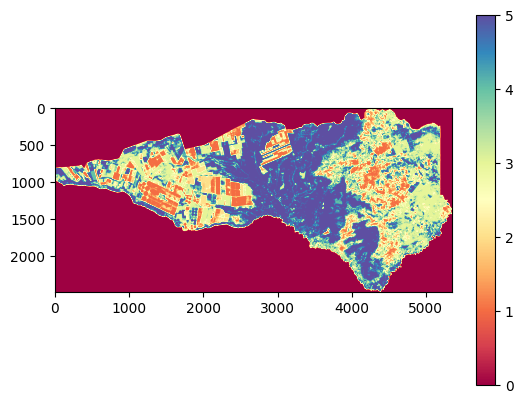

In [18]:
simplified = combined.copy()
simplified[~np.isin(combined, [0, 4, 7, 9, 1])] = 5
simplified[np.where(combined == 0)] = 0
simplified[np.where(combined == 4)] = 1
simplified[np.where(combined == 7)] = 2
simplified[np.where(combined == 9)] = 3
simplified[np.where(combined == 1)] = 4

print(np.unique(simplified))
# PLOT QUADRANT IMAGE####
fig, ax = plt.subplots()
img = ax.imshow(simplified, cmap='Spectral')
# Show Legend====
fig.colorbar(img, ax=ax)
show(simplified, ax=ax, cmap='Spectral')

In [19]:
print(combined)
~np.isin(combined, [0, 4, 7, 9, 1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [20]:
# EXPORT THE LAYER####
with rio.open("simplifiedRdn.tif",
              "w",
              width= ndmi2010.width,
              height = ndmi2010.height,
              count = 1,
              crs = ndmi2010.crs,
              transform = ndmi2010.transform,
              dtype = "uint16",
              ) as r:
        r.write(simplified, 1)

In [21]:
# CHECK OUTPUT####
print(combined.size == simplified.size)
print(combined[combined == 0].size == simplified[simplified == 0].size)
print(combined[combined == 4].size == simplified[simplified == 1].size)
print(combined[combined == 7].size == simplified[simplified == 2].size)
print(combined[combined == 9].size == simplified[simplified == 3].size)
print(combined[combined == 1].size == simplified[simplified == 4].size)

True
True
True
True
True
True


## Step4: Examine Association
Finally, we will test associations between the reclassification and irrigation gain using TOC curve. The documentation of TOC is [here](https://github.com/lazygis/pytoc).

In [22]:
# !pip3 install pytoc

In [23]:
# READ IRRIGATION GAIN DATASET AS BOOLEAN, INDEX RASTER, AND EXTENT RASTER AS NUMPY####
idx = rio.open("simplifiedRdn.tif").read(1)
irr = r"/Volumes/volume 1/GIS Projects/GISMapComparison/finalProject/irrigationsBiomas/rdn/gain1020_rdn.tif"
extr = r"/Volumes/volume 1/GIS Projects/GISMapComparison/finalProject/irrigationsBiomas/rdn/tocExtentRdn.tif"
bol = rio.open(irr).read(1)
ext = rio.open(extr).read(1)

# Check Input Files====
print(np.unique(idx))
print(np.unique(bol))
print(np.unique(ext))

[0 1 2 3 4 5]
[0 1]
[0 1]


In [24]:
# RUN TOC####
toc = TOC(bol, idx, range(1, 5), maskArray = ext)
# Print AUC====
print(toc.summary())
# Print Coordinates THAT WILL BE USED FOR LABELLING====
print(toc.TOCX)
print(toc.TOCY)

The size of extent: 13281948
Abundance: 155367
AUC: 0.9231729422631045
The coordinate of point below top left corner: (155367,15262.092396843249)
None
[[       0.  1174499.  1514910.  3190697.  3561222. 13281948.]]
[[     0. 115374. 132203. 139336. 153887. 155367.]]


In [25]:
# Check Index Position====
print(toc.TOCX[:1][0][1])
len(toc.TOCX[:1][0])

1174499.0


6

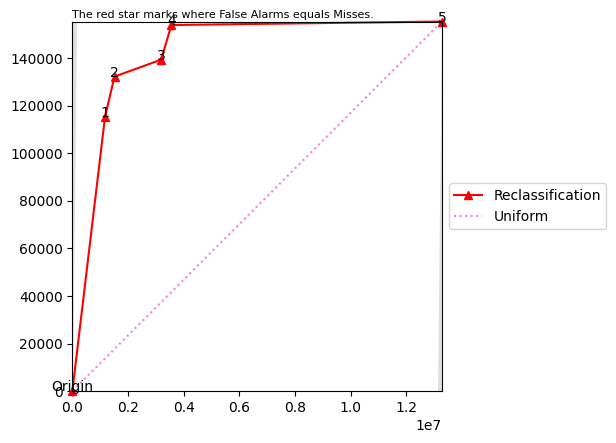

In [26]:
# DRAW TOC CURVE####
painter = TOC_painter(TOC_list=[toc], 
                      index_names=['Reclassification'], 
                      color_list=['r'], 
                      marker_list=['^'], 
                      line_list=['-'], 
                      boolUniform=True, 
                      boolCorrectCorner=True)

# Add Annotation====
for i in range(len(toc.TOCX[:1][0])):
    # Create List of Text Annotation====
    l = ["Origin", "1", "2", "3", "4", "5"]
    # Set annotation Text----
    plt.annotate(l[i],
                 # Set text posision----
                 (toc.TOCX[:1][0][i], toc.TOCY[:1][0][i]),
                 # Set horizontal alignment----
                 ha='center')
# Show TOC Curve====
painter.paint()
